In [3]:
import torch
import torchvision
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from torch.utils.data import Subset
import time

import enum


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:02<00:00, 66.2MB/s]


In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=False)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
learning_rate = 0.001
epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

num_classes = 10
loss_function = nn.CrossEntropyLoss().to(device)


Device: cuda


In [25]:
def GoogLeNet(num_classes=10, transfer=True):
  if transfer:
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT, aux_logits=True, transform_input=False)

        for param in model.parameters():
            param.requires_grad = False

        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        for param in model.inception5b.parameters():
            param.requires_grad = True

        model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

        if hasattr(model, 'aux1') and model.aux1 is not None:
            model.aux1.fc2 = nn.Linear(1024, num_classes)
        if hasattr(model, 'aux2') and model.aux2 is not None:
            model.aux2.fc2 = nn.Linear(1024, num_classes)
        return model

  else:
      model = models.googlenet(weights=None, aux_logits=False)
      model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      model.fc = nn.Linear(model.fc.in_features, num_classes)
      return model

def ResNet(num_classes = 10, transfer = True):
  if transfer:
      model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

      for param in model.parameters():
          param.requires_grad = False

      model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      model.maxpool = nn.Identity()
      model.fc = nn.Sequential(
          nn.Linear(2048, 512),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(512, num_classes)
      )

      for param in model.fc.parameters():
          param.requires_grad = True

      return model

  else:
      model = models.resnet50(weights=None)
      model.maxpool = nn.Identity()
      model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

      model.fc = nn.Linear(model.fc.in_features, num_classes)

      return model


def VGG16(num_classes = 10, transfer = True):
  if transfer:
      model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

      for param in model.parameters():
          param.requires_grad = False

      model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

      model.avgpool = nn.AdaptiveAvgPool2d((7, 7))

      model.classifier = nn.Sequential(
          nn.Linear(512 * 7 * 7, 512),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(512, num_classes)
      )

      for param in model.classifier.parameters():
          param.requires_grad = True

      return model

  else:
      model = models.vgg16(weights=None)
      model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
      model.classifier = nn.Sequential(
          nn.Linear(512 * 7 * 7, 2048),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(2048, 1024),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(1024, num_classes)
      )
      return model


In [24]:
def train(model, optimizer, train_loader):
    model.train()
    loss_list = []
    accuracy_list = []

    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)

        output = model(image)

        if hasattr(output, 'logits'):
            main_output = output.logits
            loss = loss_function(main_output, label)

            if hasattr(output, 'aux_logits') and output.aux_logits is not None:
                loss += 0.3 * loss_function(output.aux_logits[0], label)
                loss += 0.3 * loss_function(output.aux_logits[1], label)
        else:
            main_output = output
            loss = loss_function(main_output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        accuracy_list.append(torch.mean((torch.argmax(main_output, dim=1) == label).float()).item())

    return np.mean(loss_list), np.mean(accuracy_list)


In [14]:
def test(model, test_loader):
    score_list = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model.forward(images)

            score_list.append(torch.tensor(f1_score(torch.argmax(outputs, dim = 1).cpu(), labels.cpu(), average = 'macro')))

    return torch.stack(score_list).mean()


In [15]:
def exp(model):
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch}/{epochs} ")
        train_loss, accuracy_train = train(model, optimizer, train_loader)

        print(f"train loss = {train_loss :.3f}, "
              f"train accuracy = {accuracy_train:.3f} "
        )
    score_test = test(model, test_loader)
    print(f"Test score:{score_test:.3f} ")


In [ ]:
resnet50_rand = ResNet(transfer=False)
resnet50_rand = resnet50_rand.to(device)
resnet50_rand_score = exp(resnet50_rand)


Epoch: 1/20 
smth
train loss = 1.528, train accuracy = 0.451, 
Epoch: 2/20 
smth
train loss = 0.995, train accuracy = 0.647, 
Epoch: 3/20 
smth
train loss = 0.767, train accuracy = 0.732, 
Epoch: 4/20 
smth
train loss = 0.617, train accuracy = 0.786, 
Epoch: 5/20 
smth
train loss = 0.502, train accuracy = 0.825, 
Epoch: 6/20 
smth
train loss = 0.413, train accuracy = 0.857, 
Epoch: 7/20 
smth
train loss = 0.336, train accuracy = 0.884, 
Epoch: 8/20 
smth
train loss = 0.265, train accuracy = 0.906, 
Epoch: 9/20 
smth
train loss = 0.209, train accuracy = 0.927, 
Epoch: 10/20 
smth
train loss = 0.167, train accuracy = 0.941, 
Epoch: 11/20 
smth
train loss = 0.130, train accuracy = 0.954, 
Epoch: 12/20 
smth
train loss = 0.115, train accuracy = 0.959, 
Epoch: 13/20 
smth
train loss = 0.094, train accuracy = 0.967, 
Epoch: 14/20 
smth
train loss = 0.084, train accuracy = 0.971, 
Epoch: 15/20 
smth
train loss = 0.074, train accuracy = 0.974, 
Epoch: 16/20 
smth
train loss = 0.070, train accu

In [ ]:
resnet50_transfer = ResNet()
resnet50_transfer = resnet50_transfer.to(device)
resnet50_transfer_score = exp(resnet50_transfer)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Epoch: 1/20 
smth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train loss = 1.487, train accuracy = 0.472, 
Epoch: 2/20 
smth
train loss = 1.250, train accuracy = 0.559, 
Epoch: 3/20 
smth
train loss = 1.159, train accuracy = 0.595, 
Epoch: 4/20 
smth
train loss = 1.078, train accuracy = 0.626, 
Epoch: 5/20 
smth
train loss = 1.024, train accuracy = 0.645, 
Epoch: 6/20 
smth
train loss = 0.980, train accuracy = 0.661, 
Epoch: 7/20 
smth
train loss = 0.964, train accuracy = 0.666, 
Epoch: 8/20 
smth
train loss = 0.925, train accuracy = 0.679, 
Epoch: 9/20 
smth
train loss = 0.903, train accuracy = 0.690, 
Epoch: 10/20 
smth
train loss = 0.879, train accuracy = 0.697, 
Epoch: 11/20 
smth
train loss = 0.866, train accuracy = 0.700, 
Epoch: 12/20 
smth
train loss = 0.867, train accuracy = 0.701, 
Epoch: 13/20 
smth
train loss = 0.847, train accuracy = 0.708, 
Epoch: 14/20 
smth
train loss = 0.814, train accuracy = 0.720, 
Epoch: 15/20 
smth
train loss = 0.813, train accuracy = 0.718, 
Epoch: 16/20 
smth
train loss = 0.785, train accuracy = 0.730, 
Epo

In [ ]:
googlenet_rand = GoogLeNet(transfer=False)
googlenet_rand = googlenet_rand.to(device)
googlenet_rand_score = exp(googlenet_rand)

/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch: 1/20 
smth
train loss = 1.542, train accuracy = 0.425 
Epoch: 2/20 
smth
train loss = 1.049, train accuracy = 0.631 
Epoch: 3/20 
smth
train loss = 0.808, train accuracy = 0.722 
Epoch: 4/20 
smth
train loss = 0.656, train accuracy = 0.777 
Epoch: 5/20 
smth
train loss = 0.551, train accuracy = 0.814 
Epoch: 6/20 
smth
train loss = 0.464, train accuracy = 0.842 
Epoch: 7/20 
smth
train loss = 0.391, train accuracy = 0.867 
Epoch: 8/20 
smth
train loss = 0.336, train accuracy = 0.887 
Epoch: 9/20 
smth
train loss = 0.284, train accuracy = 0.903 
Epoch: 10/20 
smth
train loss = 0.239, train accuracy = 0.918 
Epoch: 11/20 
smth
train loss = 0.203, train accuracy = 0.930 
Epoch: 12/20 
smth
train loss = 0.176, train accuracy = 0.940 
Epoch: 13/20 
smth
train loss = 0.151, train accuracy = 0.948 
Epoch: 14/20 
smth
train loss = 0.134, train accuracy = 0.955 
Epoch: 15/20 
smth
train loss = 0.116, train accuracy = 0.959 
Epoch: 16/20 
smth
train loss = 0.112, train accuracy = 0.961 
E

In [26]:
googlenet_transfer = GoogLeNet()
googlenet_transfer = googlenet_transfer.to(device)
googlenet_transfer_score = exp(googlenet_transfer)

Epoch: 1/20 
train loss = 1.664, train accuracy = 0.400 
Epoch: 2/20 
train loss = 1.436, train accuracy = 0.491 
Epoch: 3/20 
train loss = 1.275, train accuracy = 0.550 
Epoch: 4/20 
train loss = 1.154, train accuracy = 0.597 
Epoch: 5/20 
train loss = 1.073, train accuracy = 0.623 
Epoch: 6/20 
train loss = 1.017, train accuracy = 0.646 
Epoch: 7/20 
train loss = 0.961, train accuracy = 0.663 
Epoch: 8/20 
train loss = 0.917, train accuracy = 0.681 
Epoch: 9/20 
train loss = 0.883, train accuracy = 0.690 
Epoch: 10/20 
train loss = 0.848, train accuracy = 0.704 
Epoch: 11/20 
train loss = 0.820, train accuracy = 0.713 
Epoch: 12/20 
train loss = 0.784, train accuracy = 0.724 
Epoch: 13/20 
train loss = 0.759, train accuracy = 0.734 
Epoch: 14/20 
train loss = 0.737, train accuracy = 0.743 
Epoch: 15/20 
train loss = 0.716, train accuracy = 0.748 
Epoch: 16/20 
train loss = 0.691, train accuracy = 0.758 
Epoch: 17/20 
train loss = 0.671, train accuracy = 0.765 
Epoch: 18/20 
train los

In [27]:
vgg16_rand = VGG16(transfer=False)
vgg16_rand = vgg16_rand.to(device)
vgg16_rand_score = exp(vgg16_rand)

Epoch: 1/20 


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train loss = 2.306, train accuracy = 0.098 
Epoch: 2/20 
train loss = 2.303, train accuracy = 0.099 
Epoch: 3/20 
train loss = 2.303, train accuracy = 0.098 
Epoch: 4/20 
train loss = 2.303, train accuracy = 0.097 
Epoch: 5/20 
train loss = 2.303, train accuracy = 0.098 
Epoch: 6/20 
train loss = 2.303, train accuracy = 0.100 
Epoch: 7/20 
train loss = 2.303, train accuracy = 0.099 
Epoch: 8/20 
train loss = 2.303, train accuracy = 0.099 
Epoch: 9/20 
train loss = 2.303, train accuracy = 0.098 
Epoch: 10/20 
train loss = 2.303, train accuracy = 0.100 
Epoch: 11/20 
train loss = 2.303, train accuracy = 0.098 
Epoch: 12/20 
train loss = 2.303, train accuracy = 0.099 
Epoch: 13/20 
train loss = 2.303, train accuracy = 0.100 
Epoch: 14/20 
train loss = 2.303, train accuracy = 0.098 
Epoch: 15/20 
train loss = 2.303, train accuracy = 0.097 
Epoch: 16/20 
train loss = 2.303, train accuracy = 0.097 
Epoch: 17/20 
train loss = 2.303, train accuracy = 0.101 
Epoch: 18/20 
train loss = 2.303, tr

In [ ]:
vgg16_transfer = VGG16()
vgg16_transfer = vgg16_transfer.to(device)
vgg16_transfer_score = exp(vgg16_transfer)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 68.6MB/s]


Epoch: 1/20 
smth
train loss = 1.800, train accuracy = 0.348 
Epoch: 2/20 
smth
train loss = 1.670, train accuracy = 0.393 
Epoch: 3/20 
smth
train loss = 1.607, train accuracy = 0.423 
Epoch: 4/20 
smth
train loss = 1.549, train accuracy = 0.445 
Epoch: 5/20 
smth
train loss = 1.506, train accuracy = 0.463 
Epoch: 6/20 
smth
train loss = 1.481, train accuracy = 0.473 
Epoch: 7/20 
smth
train loss = 1.452, train accuracy = 0.484 
Epoch: 8/20 
smth
train loss = 1.428, train accuracy = 0.495 
Epoch: 9/20 
smth
train loss = 1.419, train accuracy = 0.499 
Epoch: 10/20 
smth
train loss = 1.402, train accuracy = 0.507 
Epoch: 11/20 
smth
train loss = 1.381, train accuracy = 0.513 
Epoch: 12/20 
smth
train loss = 1.369, train accuracy = 0.518 
Epoch: 13/20 
smth
train loss = 1.364, train accuracy = 0.522 
Epoch: 14/20 
smth
train loss = 1.345, train accuracy = 0.527 
Epoch: 15/20 
smth
train loss = 1.339, train accuracy = 0.531 
Epoch: 16/20 
smth
train loss = 1.332, train accuracy = 0.536 
E

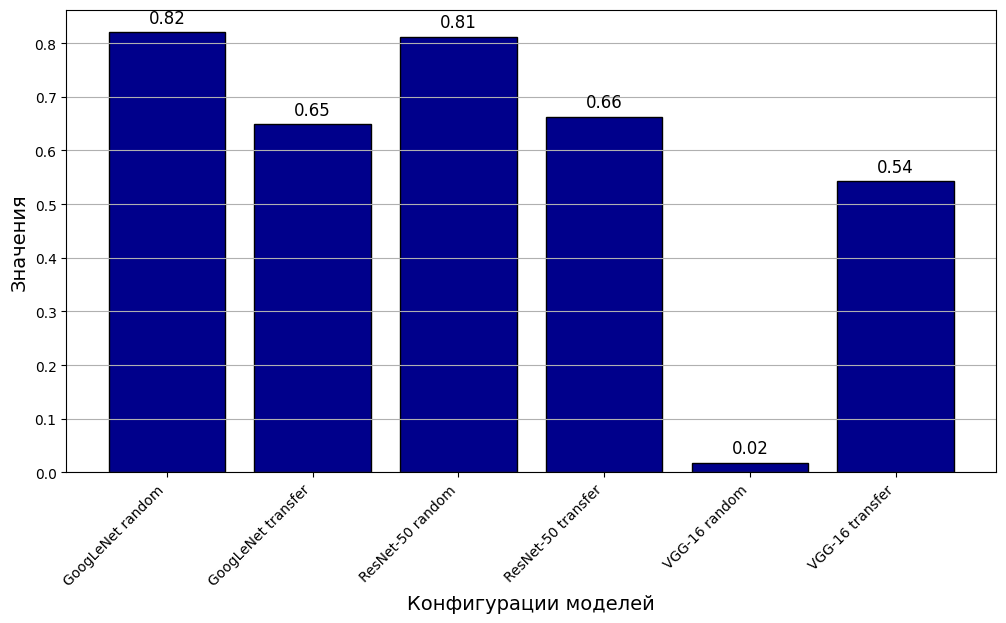

In [31]:
name_models = [
    'GoogLeNet random',
    'GoogLeNet transfer',
    'ResNet-50 random',
    'ResNet-50 transfer',
    'VGG-16 random',
    'VGG-16 transfer',
]

test = [
    0.82,
    0.649,
    0.812,
    0.663,
    0.018,
    0.543
]

plt.figure(figsize=(12, 6))
bars = plt.bar(name_models, test, color = 'darkblue', edgecolor = 'black')
plt.xlabel("Конфигурации моделей", fontsize = 14)
plt.ylabel("Значения", fontsize = 14)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation = 45, ha = 'right')
plt.grid(axis='y')
plt.show()
